## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import random

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [5]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

#assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
#assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [ ]:
text[:100]

"  from fairest creatures we desire increase,\n  that thereby beauty's rose might never die,\n  but as "

### Data loading: "Евгений Онегин"


In [ ]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

# with open('onegin.txt', 'r') as iofile:
#     text = iofile.readlines()

# text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

Put all the characters, that you've seen in the text, into variable `tokens`.

In [7]:
tokens = sorted(set(text))
print(len(tokens))

38


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [8]:
id_to_token = {idx: token for idx, token in enumerate(tokens)}
token_to_id = {token: idx for idx, token in enumerate(tokens)}

num_tokens = len(tokens)
text_encoded = [token_to_id[x] for x in text]

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [10]:
# Кодирование текста
text_encoded = [token_to_id[ch] for ch in text]

# Параметры модели
SEQ_LENGTH = 100  # Длина последовательности для обучения
HIDDEN_SIZE = 128  # Размер скрытого состояния
NUM_LAYERS = 2     # Количество слоев RNN
LEARNING_RATE = 0.005
NUM_EPOCHS = 100
BATCH_SIZE = 32

# Создание обучающих данных
def create_sequences(data, seq_length):
    sequences = []
    targets = []

    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + 1:i + seq_length + 1]
        sequences.append(seq)
        targets.append(target)

    return torch.tensor(sequences), torch.tensor(targets)

X, y = create_sequences(text_encoded, SEQ_LENGTH)

# Определение модели RNN
class ShakespeareRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(ShakespeareRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        # Размеры: x: (batch_size, seq_length)
        batch_size = x.size(0)

        if hidden is None:
            hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)

        embedded = self.embedding(x)  # (batch_size, seq_length, hidden_size)
        output, hidden = self.rnn(embedded, hidden)
        output = self.fc(output)  # (batch_size, seq_length, output_size)

        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

# Инициализация модели
model = ShakespeareRNN(num_tokens, HIDDEN_SIZE, num_tokens, NUM_LAYERS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Обучение модели
train_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0

    # Перемешиваем данные
    indices = torch.randperm(len(X))
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    for i in range(0, len(X), BATCH_SIZE):
        batch_X = X_shuffled[i:i+BATCH_SIZE]
        batch_y = y_shuffled[i:i+BATCH_SIZE]

        optimizer.zero_grad()

        # Forward pass
        output, hidden = model(batch_X)

        # Reshape для loss функции
        output = output.reshape(-1, num_tokens)
        batch_y = batch_y.reshape(-1)

        loss = criterion(output, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / (len(X) / BATCH_SIZE)
    train_losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}')

# Функция для генерации текста
def generate_text(model, start_text, length=500, temperature=0.8):
    model.eval()

    # Преобразуем начальный текст в последовательность индексов
    start_tokens = [token_to_id[ch] for ch in start_text.lower()]
    generated = start_tokens.copy()

    with torch.no_grad():
        hidden = None

        # Подаем начальную последовательность
        if len(start_tokens) > 1:
            input_seq = torch.tensor([start_tokens[:-1]]).long()
            output, hidden = model(input_seq)

        # Генерируем новые токены
        current_token = torch.tensor([[start_tokens[-1]]]).long()

        for _ in range(length):
            output, hidden = model(current_token, hidden)

            # Получаем вероятности следующего токена
            logits = output[0, -1, :] / temperature
            probabilities = torch.softmax(logits, dim=0)

            # Выбираем токен на основе вероятностей
            next_token = torch.multinomial(probabilities, 1).item()

            generated.append(next_token)
            current_token = torch.tensor([[next_token]]).long()

    # Преобразуем индексы обратно в текст
    generated_text = ''.join([id_to_token[token_id] for token_id in generated])

    return generated_text

# Генерация текста
print("\n" + "="*50)
print("ГЕНЕРАЦИЯ ТЕКСТА В СТИЛЕ ШЕКСПИРА")
print("="*50)

start_phrases = [
    "shall i compare thee",
    "my mistress eyes",
    "when i do count",
    "love is not love",
    "from fairest creatures"
]

for i, phrase in enumerate(start_phrases):
    generated = generate_text(model, phrase, length=300, temperature=0.7)
    print(f"\nПример {i+1} (стартовая фраза: '{phrase}'):")
    print("-" * 50)

    # Форматируем вывод как сонет
    lines = generated.split('\n')
    for j, line in enumerate(lines[:14]):  # Показываем первые 14 строк
        if j < 14:
            print(f"  {line}")

    if len(lines) > 14:
        print("  ...")
    print()

Epoch [10/100], Loss: 1.5683
Epoch [20/100], Loss: 1.4163
Epoch [30/100], Loss: 1.5018
Epoch [40/100], Loss: 1.5502
Epoch [50/100], Loss: 1.5363
Epoch [60/100], Loss: 1.5369
Epoch [70/100], Loss: 1.5518
Epoch [80/100], Loss: 1.5265
Epoch [90/100], Loss: 1.5365
Epoch [100/100], Loss: 1.5337

ГЕНЕРАЦИЯ ТЕКСТА В СТИЛЕ ШЕКСПИРА

Пример 1 (стартовая фраза: 'shall i compare thee'):
--------------------------------------------------
  shall i compare thee mine it so to chart's swart'right,
      what full other'd you art,
      that to time and the for thee ut thy her doth perk the thee;
    to date to the with prove, and self in some it for my state that the shall thee and ball like fair; thou have that green.
  
    cxxxvii
  
    what thy most preat the love t


Пример 2 (стартовая фраза: 'my mistress eyes'):
--------------------------------------------------
  my mistress eyes am of the bemongue-dord,
    more i not, and beauty in make disprest with mine, but un me of the sweet of and map

Plot the loss function (axis X: number of epochs, axis Y: loss function).

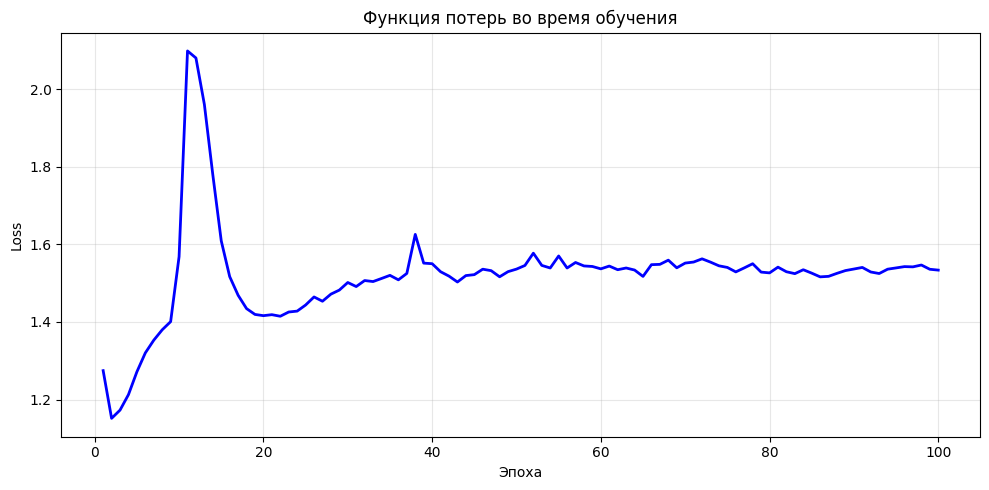

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Построение графика функции потерь
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'b-', linewidth=2)
plt.title('Функция потерь во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

hide my will in thine?
  shall will in of the simend that in my sime the seave the seave the sorll the soren the sange the seall seares and and the fart the wirl the seall the songh whing that thou hall will thoun the soond beare the with that sare the simest me the fart the wirl the songre the with thy seart so for shat so for do the dost the sing the sing the sing the soond canding the sack and the farling the wirl of sore sich and that with the seare the seall so fort the with the past the wirl the simen the wirl the sores the sare


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
class ShakespeareLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(ShakespeareLSTM, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        output, hidden = self.lstm(embedded, hidden)
        return self.fc(output), hidden

# Инициализация и обучение LSTM
lstm_model = ShakespeareLSTM(num_tokens, HIDDEN_SIZE, num_tokens, NUM_LAYERS)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
lstm_losses = []

print("\n=== Обучение LSTM ===")

for epoch in range(NUM_EPOCHS):
    lstm_model.train()
    total_loss = 0

    indices = torch.randperm(len(X))
    X_shuffled, y_shuffled = X[indices], y[indices]

    for i in range(0, len(X), BATCH_SIZE):
        batch_X, batch_y = X_shuffled[i:i+BATCH_SIZE], y_shuffled[i:i+BATCH_SIZE]

        lstm_optimizer.zero_grad()
        output, _ = lstm_model(batch_X)

        loss = criterion(output.view(-1, num_tokens), batch_y.view(-1))
        loss.backward()
        lstm_optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / (len(X) / BATCH_SIZE)
    lstm_losses.append(avg_loss)

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}')


print(f"\n=== Результаты ===")
print(f"RNN финальный loss: {train_losses[-1]:.4f}")
print(f"LSTM финальный loss: {lstm_losses[-1]:.4f}")

if lstm_losses[-1] < train_losses[-1]:
    improvement = (train_losses[-1] - lstm_losses[-1]) / train_losses[-1] * 100
    print(f"LSTM лучше на {improvement:.1f}%")
else:
    print("RNN лучше")

# График
plt.figure(figsize=(8, 5))
plt.plot(train_losses, 'b-', label='RNN')
plt.plot(lstm_losses, 'r-', label='LSTM')
plt.title('Сравнение RNN и LSTM')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Быстрая проверка генерации
print("\n=== Тест генерации (первые 100 символов) ===")
start_phrase = "shall i compare thee"

for name, model in [("RNN", model), ("LSTM", lstm_model)]:
    model.eval()
    with torch.no_grad():
        tokens = [token_to_id[ch] for ch in start_phrase.lower()]
        generated = tokens.copy()
        hidden = None

        if len(tokens) > 1:
            input_seq = torch.tensor([tokens[:-1]]).long()
            _, hidden = model(input_seq)

        current = torch.tensor([[tokens[-1]]]).long()

        for _ in range(100):
            output, hidden = model(current, hidden)
            probs = torch.softmax(output[0, -1, :] / 0.7, dim=0)
            next_token = torch.multinomial(probs, 1).item()
            generated.append(next_token)
            current = torch.tensor([[next_token]]).long()

    text = ''.join([id_to_token[t] for t in generated])
    print(f"\n{name}: {text[:100]}...")


=== Обучение LSTM ===


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:

def generate_text(model, start_text, length=200, temperature=1.0):
    model.eval()
    tokens = [token_to_id[ch] for ch in start_text.lower()]
    generated = tokens.copy()

    with torch.no_grad():
        hidden = None
        if len(tokens) > 1:
            _, hidden = model(torch.tensor([tokens[:-1]]).long())

        current = torch.tensor([[tokens[-1]]]).long()
        for _ in range(length):
            output, hidden = model(current, hidden)
            probs = torch.softmax(output[0, -1, :] / temperature, dim=0)
            next_token = torch.multinomial(probs, 1).item()
            generated.append(next_token)
            current = torch.tensor([[next_token]]).long()

    return ''.join([id_to_token[t] for t in generated])

# Генерация
print("\n=== Генерация с разными temperature ===\n")
start_phrase = "shall i compare thee"

for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    text = generate_text(lstm_model, start_phrase, length=200, temperature=temp)

    print(f"Temperature = {temp}:")
    print("-" * 40)

    # Показываем первые 100 символов
    lines = text.split('\n')[:3]
    for line in lines:
        if line.strip():
            print(f"  {line[:60]}" + ("..." if len(line) > 60 else ""))

    # Статистика
    unique_chars = len(set(text[:100]))
    print(f"  [Уникальных символов: {unique_chars}]")
    print()

# Визуализация
print("\n=== Визуализация влияния temperature ===\n")

# Анализ первого символа после фразы
model.eval()
with torch.no_grad():
    input_tokens = torch.tensor([[token_to_id[ch] for ch in start_phrase.lower()]]).long()
    output, _ = lstm_model(input_tokens)
    logits = output[0, -1, :]

    print("Вероятности первого следующего символа:")
    for temp in [0.1, 0.5, 1.0]:
        probs = torch.softmax(logits / temp, dim=0)
        top_probs, top_indices = torch.topk(probs, 3)

        print(f"\nTemperature = {temp}:")
        for prob, idx in zip(top_probs, top_indices):
            char = id_to_token[idx.item()]
            if char == '\n': char = '\\n'
            print(f"  '{char}': {prob.item():.3f}")

# Итог
print("\n=== Итог по temperature ===")
print("0.1-0.2: Консервативно, повторяющиеся паттерны")
print("0.5: Баланс креативности и структуры")
print("1.0: Естественное разнообразие")
print("2.0: Случайно, может быть бессвязным")

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
torch.save(lstm_model.state_dict(), 'shakespeare_lstm.pth')

import pickle
model_data = {
    'token_to_id': token_to_id,
    'id_to_token': id_to_token,
    'params': (num_tokens, HIDDEN_SIZE, NUM_LAYERS)
}
with open('model_data.pkl', 'wb') as f:
    pickle.dump(model_data, f)


with open('model_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

token_to_id = loaded_data['token_to_id']
id_to_token = loaded_data['id_to_token']
num_tokens, HIDDEN_SIZE, NUM_LAYERS = loaded_data['params']

loaded_model = ShakespeareLSTM(num_tokens, HIDDEN_SIZE, num_tokens, NUM_LAYERS)
loaded_model.load_state_dict(torch.load('shakespeare_lstm.pth'))
loaded_model.eval()


def generate(model, start_text, length=100, temp=0.7):
    model.eval()
    tokens = [token_to_id[ch] for ch in start_text.lower()]
    generated = tokens.copy()

    with torch.no_grad():
        hidden = None
        if len(tokens) > 1:
            _, hidden = model(torch.tensor([tokens[:-1]]).long())

        current = torch.tensor([[tokens[-1]]]).long()
        for _ in range(length):
            output, hidden = model(current, hidden)
            probs = torch.softmax(output[0, -1, :] / temp, dim=0)
            next_token = torch.multinomial(probs, 1).item()
            generated.append(next_token)
            current = torch.tensor([[next_token]]).long()

    return ''.join([id_to_token[t] for t in generated])

# Тест
text = generate(loaded_model, "shall i compare", length=80, temp=0.7)
print(f"  {text[:60]}...")

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)